In [12]:
%load_ext autoreload
%autoreload 2
import torch

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache_bert')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> current directory : C:\Users\loicf\Documents\IRISA\TALN_2023\AttentionGeometry
>> cache path : C:\Users\loicf\Documents\IRISA\TALN_2023\AttentionGeometry\.cache_bert
>> model path : C:\Users\loicf\Documents\IRISA\TALN_2023\AttentionGeometry\.cache_bert\models
>> dataset path : C:\Users\loicf\Documents\IRISA\TALN_2023\AttentionGeometry\.cache_bert\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\TALN_2023\AttentionGeometry\.cache_bert\logs


In [13]:
DEVICE

device(type='cuda')

In [14]:
from datasets import load_dataset
dataset = load_dataset("yelp_polarity", split='test')

Reusing dataset yelp_polarity (C:\Users\loicf\.cache\huggingface\datasets\yelp_polarity\plain_text\1.0.0\14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61)


In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [16]:
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True).shuffle()

  0%|          | 0/38 [00:00<?, ?ba/s]

In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(log_path, "yelp", "yelp-ft-3"),
    num_labels=2,
    output_hidden_states=True
)
model = model.eval()
model=model.to(DEVICE)

In [18]:
# get the r_i
import numpy as np
with torch.no_grad():
    class_1 = 0
    r_0 = None
    for i in range(len(tokenized_datasets)):
        ex = tokenized_datasets[i]
        label = tokenized_datasets[i]["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE)
        )
        pred = output_model.logits
        if label == class_1 and np.argmax(pred.detach().cpu().numpy()) == label:
            print( np.argmax(pred.detach().cpu().numpy()))
            print(label)
            r_0 = output_model.hidden_states[-1][0, 0, :]
            print("pred found")
            break

0
0
pred found


In [19]:
# get the r_i
import numpy as np
with torch.no_grad():
    class_1 = 1
    r_1 = None
    for i in range(len(tokenized_datasets)):
        ex = tokenized_datasets[i]
        label = tokenized_datasets[i]["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE)
        )
        pred = output_model.logits
        if label == class_1 and np.argmax(pred.detach().cpu().numpy()) == label:
            print( np.argmax(pred.detach().cpu().numpy()))
            print(label)
            r_1 = output_model.hidden_states[-1][0, 0, :]
            print("pred found")
            break

1
1
pred found


In [27]:
cos_res = []
legend = []
ds = tokenized_datasets
from tqdm.notebook import tqdm
r_0 = r_0.to(DEVICE)
r_1 = r_1.to(DEVICE)

data1 = [[], []]
data2 = [[], []]

predictions = []

with torch.no_grad():
    for i in tqdm(range(len(tokenized_datasets))):
        ex = ds[i]
        label = ex["label"]
        
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE),
        )
        
        pred = torch.argmax(output_model.logits, dim=-1).item()
        predictions.append(pred)

        temp = output_model.hidden_states[-1][0, 0, :]
        
        scalar = torch.dot(r_0, temp)
        temp1 = (scalar / (torch.norm(temp) * torch.norm(r_0))).item()
        
        scalar = torch.dot(r_1, temp)
        temp2 = (scalar / (torch.norm(temp) * torch.norm(r_1))).item()
        
        if label==0:
            data1[0].append(temp1)
            data2[1].append(temp2)
        else:
            data1[1].append(temp2)
            data2[0].append(temp1)
        
            
            
        
            
        
        
        
        
        
        legend.append(label)
        if i > 5000:
            break

  0%|          | 0/38000 [00:00<?, ?it/s]

In [30]:
predictions = np.array(predictions)
labels = np.array(legend)
acc_res = []
for i in range(2):
    mask = labels==i
    acc_res.append((predictions[mask]==i).mean())
    

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tikzplotlib

C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


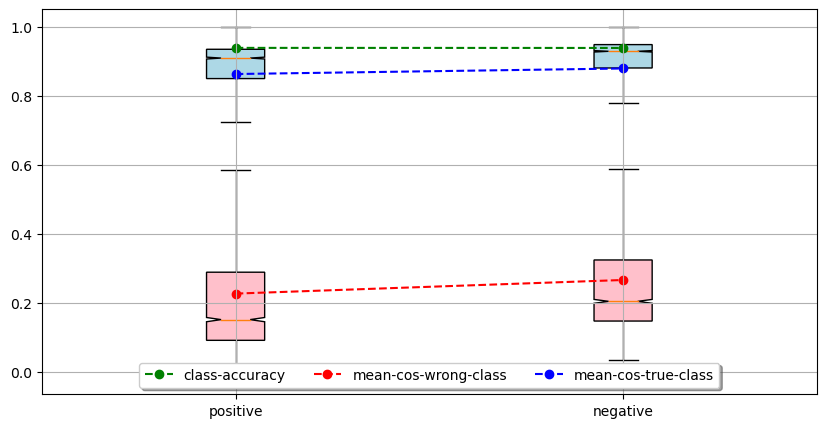

In [32]:
x = [0, 1]
figure, ax = plt.subplots(1, 1, figsize=(10, 5))
bplot1 = ax.boxplot(data1, showfliers=False, patch_artist=True, notch=True, zorder=-1)
bplot2 = ax.boxplot(data2, showfliers=False, patch_artist=True, notch=True, zorder=-1)
for patch in bplot1['boxes']:
    patch.set_facecolor("lightblue")
    
for patch in bplot2['boxes']:
    patch.set_facecolor("pink")

y1 = []
y2 = []
for i in range(2):
    y1.append(np.array(data1[i]).mean())
    y2.append(np.array(data2[i]).mean())
ax.plot(np.array(x)+1, acc_res, "o--", label="class-accuracy", color="green", zorder=1)
ax.plot(np.array(x)+1, y2, "o--", label="mean-cos-wrong-class", color="red", zorder=1)
ax.plot(np.array(x)+1, y1, "o--", label="mean-cos-true-class", color="blue", zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(list(range(1, 3)))
ax.set_xticklabels(["positive", "negative"])
ax.grid()
temp = ax.set(
    #xlabel="label-id"
)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "yelp-boxplot.png"))